# MLP 2-Layer with Federated Learning (Global Aggregation)

This notebook implements a 2-layer Multi-Layer Perceptron (MLP) with Federated Learning. The architecture consists of:
- **2-Layer MLP**: Input layer → Hidden layer (32 neurons, ReLU) → Output layer (10 neurons)
- **Federated Learning**: Multiple clients train locally, then aggregate updates globally

## Overview
Federated learning allows training on distributed data without sharing raw data. Each client trains on local data, and model updates are aggregated at a central server.



In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.random.seed(3)

## Import Required Libraries

Import libraries for neural network implementation, data handling, and visualization.


In [ ]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

## Define Linear Layer Class

Implement a fully connected (linear) layer with forward and backward propagation:
- **forward**: Computes linear transformation (WX + b)
- **backward**: Computes gradients for weights, bias, and input


In [ ]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    out= exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return out

class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        # raise ValueError (y.shape)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = cross_entropy[0] / self.m
        return loss

    def backward(self, X, y):
        y_idx = y.argmax()
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

## Define ReLU Activation and Loss Functions

Implement:
- **ReLU**: Rectified Linear Unit activation function
- **Softmax**: Converts logits to probabilities
- **CrossEntropy**: Cross-entropy loss function for classification


In [ ]:
from keras.datasets import mnist
# from keras.utils import np_utils


(train_features, train_targets), (test_features, test_targets) = mnist.load_data()


train_features = train_features.reshape(60000, 784)
print(train_features.shape)
test_features = test_features.reshape(10000, 784)
print(test_features.shape)


# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

print(train_targets.shape)
print(test_targets.shape)

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets


(60000, 784)
(10000, 784)
(60000,)
(10000,)


## Load and Prepare MNIST Dataset

Load the MNIST handwritten digit dataset:
- Reshape images from 28x28 to 784-dimensional vectors
- Normalize pixel values from 0-255 to 0-1
- Split into training and validation sets


In [ ]:
class NN():
    def __init__(self, lossfunc=CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []

    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads

    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        l2 = self.backward(nextgrad)
        return loss, l2

    def predict(self, X):
        X = self.forward(X)
        return np.argmax(X, axis=1)

    def predict_scores(self, X):
        X = self.forward(X)
        return X

    def clear_grad_param(self):
        self.grads = []

## Define Neural Network Class

Implement the main neural network class that:
- Manages multiple layers
- Performs forward and backward propagation
- Handles training steps and predictions


In [ ]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]


## Define Parameter Update Function

Implement momentum-based parameter update using gradient descent with momentum (SGD with momentum).


In [ ]:
def minibatch(X, y, minibatch_size):
    X = np.array(X)
    y = np.array(y)

    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]

    for i in range(0, X.shape[0], minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size]  # Adjusted indexing here
        minibatches.append((X_batch, y_batch))

    return minibatches


## Define Minibatch Function

Create minibatches from the dataset by randomly shuffling and splitting data into smaller batches for efficient training.


In [ ]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)


    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)

        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)

        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))

        # raise ValueError(y_train_pred.shape)
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))

        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

## Define Training Function

Implement the training loop that:
- Trains the network using minibatches
- Uses momentum-based optimization
- Tracks training and validation loss and accuracy
- Returns the trained model


In [ ]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

## Define Accuracy Check Function

Calculate classification accuracy by comparing predicted labels with true labels.


In [ ]:
def get_model_updates(local_model, global_model):
    model_updates = []  # Placeholder for the updates

    for local_layer, global_layer in zip(local_model.layers, global_model.layers):
        # Assuming each layer has parameters and gradients
        layer_updates = []
        for local_param, global_param in zip(local_layer.params, global_layer.params):
            # Compute the update (e.g., gradients or updated parameters)
            update = local_param - global_param
            layer_updates.append(update)

        model_updates.append(layer_updates)

    return model_updates

def aggregate_updates(global_model, client_updates):
    updated_global_model = global_model # Copy the global model

    for global_layer, layer_updates in zip(updated_global_model.layers, zip(*client_updates)):
        for global_param, layer_update in zip(global_layer.params, zip(*layer_updates)):
            # Aggregate updates (e.g., average or weighted average)
            weights=np.array([1/6,3/6,2/6])
            global_param += np.average(layer_update,weights=weights)  # Example: average updates

    return updated_global_model

## Define Federated Learning Functions

Implement federated learning components:
- **get_model_updates**: Computes model updates (difference between local and global models)
- **aggregate_updates**: Aggregates updates from all clients using weighted averaging


Round:1
Client:1
Loss = 0.007578011696308684 | Training Accuracy = 0.8643 | Val Loss = 0.0010959902645239223 | Val Accuracy = 0.835
Loss = 0.0020054936497347652 | Training Accuracy = 0.916 | Val Loss = 0.001890956013012851 | Val Accuracy = 0.893
Loss = 0.0017826547934594098 | Training Accuracy = 0.93 | Val Loss = 0.001421485538284996 | Val Accuracy = 0.898
Loss = 0.0016882003377112537 | Training Accuracy = 0.9395 | Val Loss = 0.0017168524776162556 | Val Accuracy = 0.899
Loss = 0.0014949340600346574 | Training Accuracy = 0.9494 | Val Loss = 0.002084733058130199 | Val Accuracy = 0.911
Loss = 0.0014910742239659263 | Training Accuracy = 0.9557 | Val Loss = 0.002026898115521354 | Val Accuracy = 0.913
Loss = 0.0015679190906008331 | Training Accuracy = 0.9573 | Val Loss = 0.0016528364305383348 | Val Accuracy = 0.914
Loss = 0.0016211168791497184 | Training Accuracy = 0.9605 | Val Loss = 0.0013286964780687934 | Val Accuracy = 0.909
Loss = 0.0014846499130300708 | Training Accuracy = 0.9621 | Val

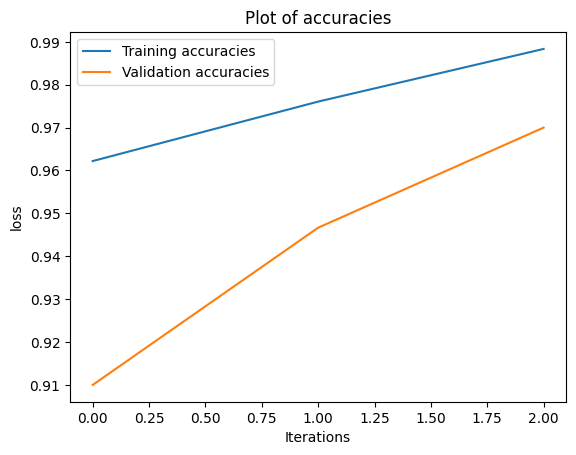

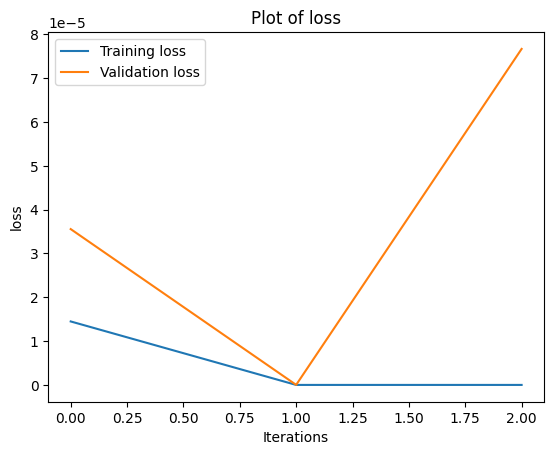

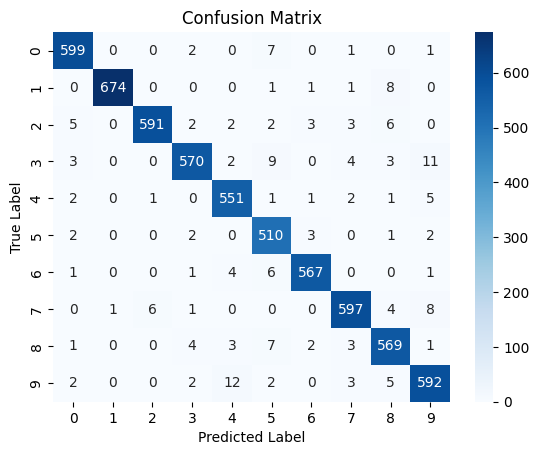

Round:2
Client:1
Loss = 0.0010138491811057242 | Training Accuracy = 0.9719 | Val Loss = 0.00010674433283118989 | Val Accuracy = 0.965
Loss = 0.0008376602687440138 | Training Accuracy = 0.9746 | Val Loss = 1.853278158726618e-05 | Val Accuracy = 0.961
Loss = 0.0006879238776759968 | Training Accuracy = 0.9748 | Val Loss = 2.7460975101322703e-05 | Val Accuracy = 0.955
Loss = 0.0005266790749163789 | Training Accuracy = 0.9796 | Val Loss = 2.285975986946549e-05 | Val Accuracy = 0.962
Loss = 0.0003700143243924919 | Training Accuracy = 0.9839 | Val Loss = 1.0677789422864185e-05 | Val Accuracy = 0.959
Loss = 0.00030538106090615753 | Training Accuracy = 0.987 | Val Loss = 5.456868140862983e-06 | Val Accuracy = 0.964
Loss = 0.00025929659221392434 | Training Accuracy = 0.9904 | Val Loss = 8.515473709584238e-06 | Val Accuracy = 0.965
Loss = 0.00018342726530888478 | Training Accuracy = 0.9931 | Val Loss = 2.6017214822920434e-05 | Val Accuracy = 0.969
Loss = 0.00014273998589370754 | Training Accuracy

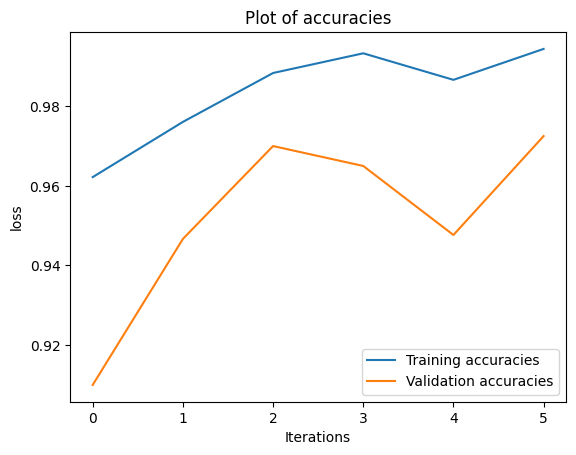

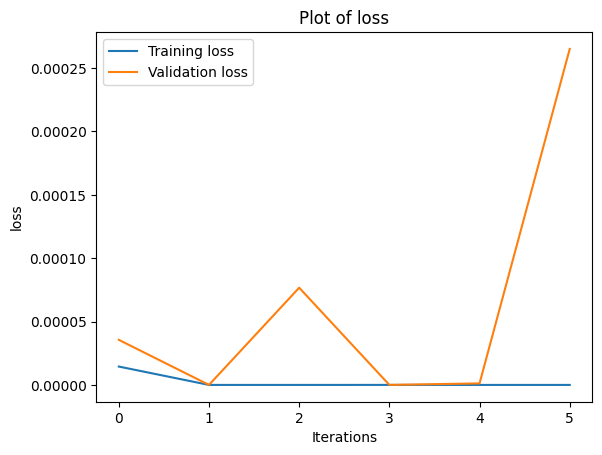

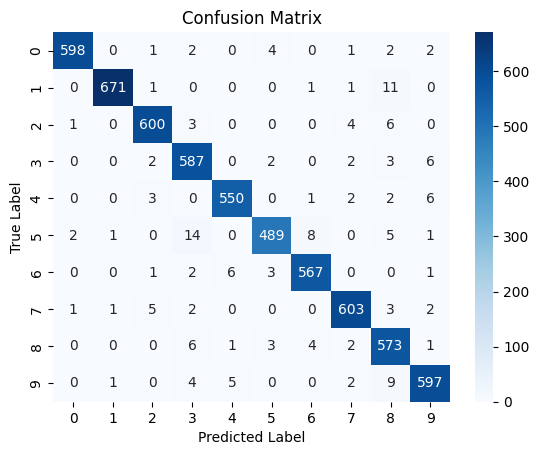

Round:3
Client:1
Loss = 0.00030190029456429626 | Training Accuracy = 0.9761 | Val Loss = 0.00017973872734742787 | Val Accuracy = 0.957
Loss = 0.00010546551346161289 | Training Accuracy = 0.9856 | Val Loss = 0.00025563001088142696 | Val Accuracy = 0.966
Loss = 4.860832997031496e-05 | Training Accuracy = 0.9881 | Val Loss = 0.00033775563809110916 | Val Accuracy = 0.961
Loss = 6.130066237163955e-05 | Training Accuracy = 0.9895 | Val Loss = 0.0004694628321100064 | Val Accuracy = 0.962
Loss = 5.843820655653208e-05 | Training Accuracy = 0.9933 | Val Loss = 0.00021258093814564095 | Val Accuracy = 0.963
Loss = 4.4197741993853895e-05 | Training Accuracy = 0.994 | Val Loss = 0.00017897647717158565 | Val Accuracy = 0.958
Loss = 4.6046585574598894e-05 | Training Accuracy = 0.9935 | Val Loss = 0.00014853956749154312 | Val Accuracy = 0.96
Loss = 6.588548385366225e-05 | Training Accuracy = 0.9942 | Val Loss = 3.784341207727291e-05 | Val Accuracy = 0.962
Loss = 5.349136525958603e-05 | Training Accurac

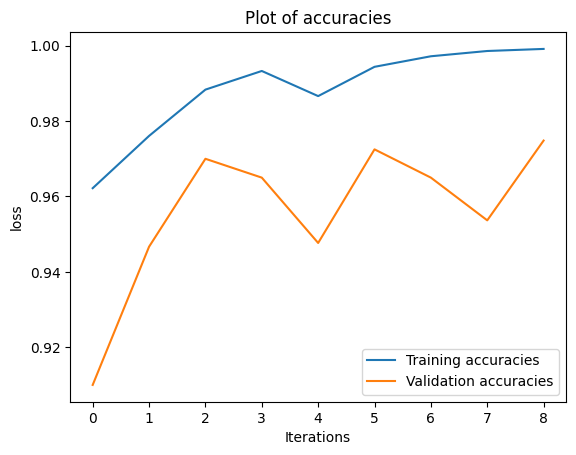

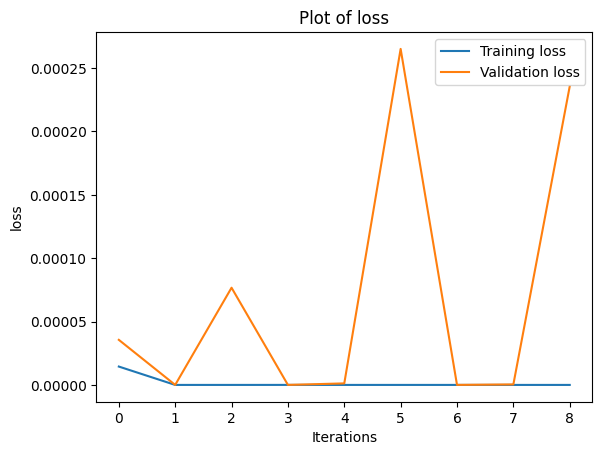

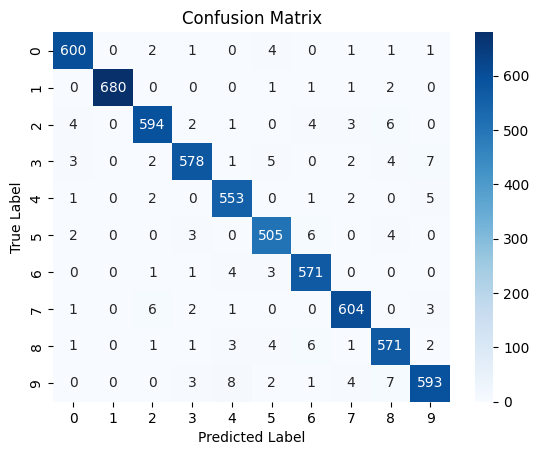

Round:4
Client:1
Loss = 0.0001967480440581052 | Training Accuracy = 0.982 | Val Loss = 1.2298244009067988e-09 | Val Accuracy = 0.962
Loss = 0.00017070823050624776 | Training Accuracy = 0.9886 | Val Loss = 6.431221563677754e-10 | Val Accuracy = 0.966
Loss = 0.00011414696036300876 | Training Accuracy = 0.993 | Val Loss = 9.201985093886333e-09 | Val Accuracy = 0.966
Loss = 3.9319489243709585e-05 | Training Accuracy = 0.9949 | Val Loss = 1.272990687264528e-09 | Val Accuracy = 0.965
Loss = 6.5572363268967e-05 | Training Accuracy = 0.9959 | Val Loss = 5.266105884456618e-10 | Val Accuracy = 0.964
Loss = 2.2036092276966254e-05 | Training Accuracy = 0.996 | Val Loss = 9.574356565975014e-11 | Val Accuracy = 0.967
Loss = 1.6332937125840258e-05 | Training Accuracy = 0.997 | Val Loss = 2.2606752077028628e-11 | Val Accuracy = 0.969
Loss = 1.6171159806597525e-05 | Training Accuracy = 0.9976 | Val Loss = 1.072006262686892e-11 | Val Accuracy = 0.967
Loss = 1.6286321256702867e-05 | Training Accuracy = 0

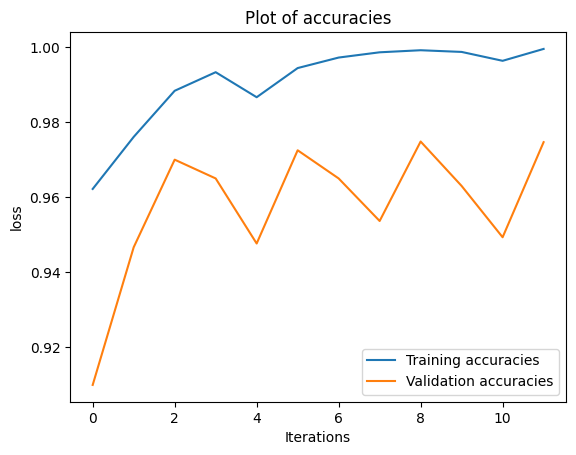

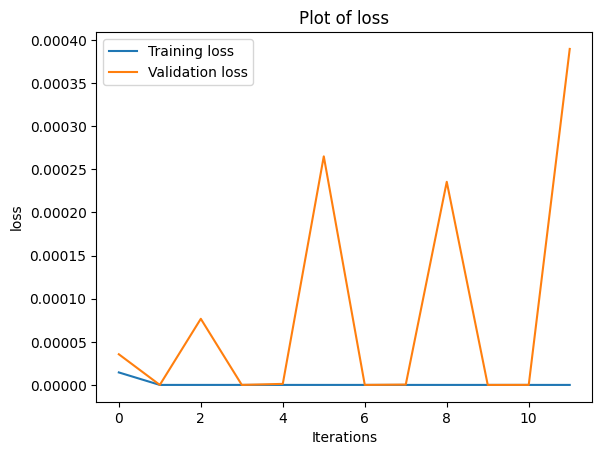

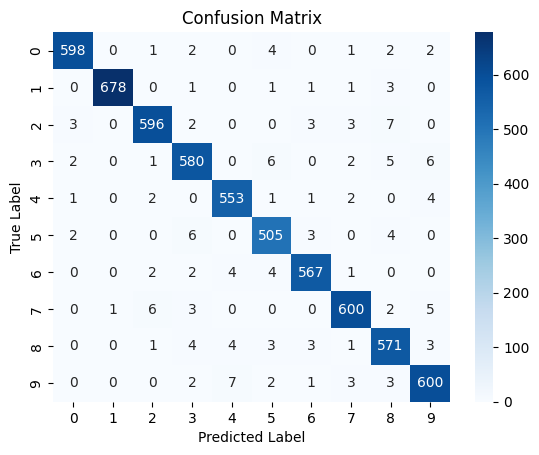

Round:5
Client:1
Loss = 0.00018521208195124484 | Training Accuracy = 0.9842 | Val Loss = 1.0214151747666946e-12 | Val Accuracy = 0.958
Loss = 0.00014786085988203294 | Training Accuracy = 0.9917 | Val Loss = 1.6103929303774463e-12 | Val Accuracy = 0.961
Loss = 4.337538840438608e-05 | Training Accuracy = 0.9905 | Val Loss = 5.5118287460455024e-11 | Val Accuracy = 0.965
Loss = 5.9176733023879996e-06 | Training Accuracy = 0.9922 | Val Loss = 5.55736588212638e-10 | Val Accuracy = 0.969
Loss = 9.825844633882355e-06 | Training Accuracy = 0.9965 | Val Loss = 8.386911846521739e-11 | Val Accuracy = 0.967
Loss = 9.903037813216149e-06 | Training Accuracy = 0.9982 | Val Loss = 4.149111349500696e-11 | Val Accuracy = 0.962
Loss = 6.34648149221386e-06 | Training Accuracy = 0.9993 | Val Loss = 4.825568801185862e-11 | Val Accuracy = 0.965
Loss = 3.946487269009453e-06 | Training Accuracy = 0.9993 | Val Loss = 2.01846539890051e-11 | Val Accuracy = 0.966
Loss = 4.301037113777156e-06 | Training Accuracy = 0

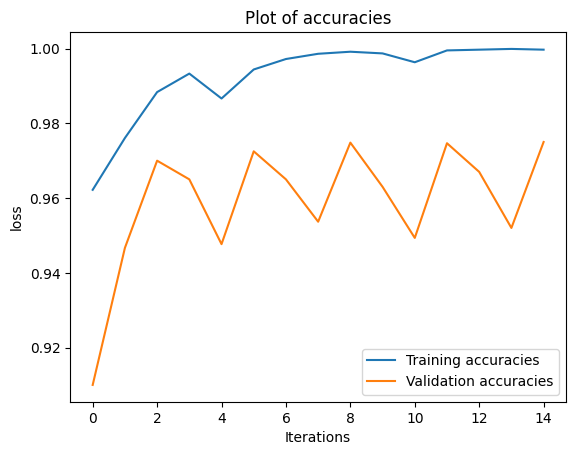

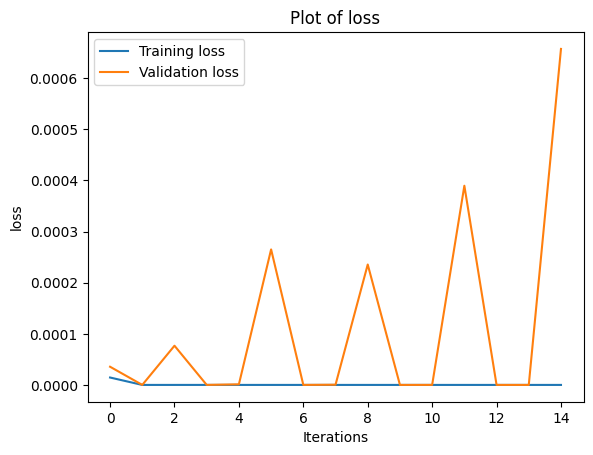

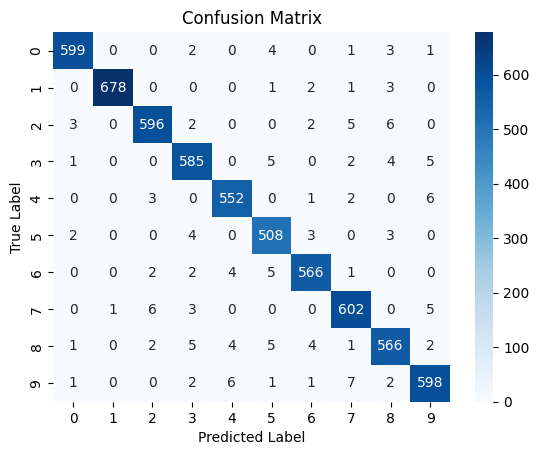

In [ ]:
def federated_train(global_nn, clients_data, num_rounds, learning_rate):
    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []
    all_conf_matrices = []

    for round_num in range(num_rounds):
        print(f'Round:{round_num+1}')
        client_number=0
        for client_num, client_data in enumerate(clients_data):
            print(f'Client:{client_number+1}')

            local_nn = global_nn  # Copy the global model to the client
            X_client, y_client, X_val_client, y_val_client = client_data

            # Train the local model on the client's data
            local_nn = train(local_nn, X_client, y_client, minibatch_size=200, epoch=10, learning_rate=learning_rate, X_val=X_val_client, y_val=y_val_client)

            # Get training and validation losses
            train_loss, _ = local_nn.train_step(X_client, y_client)
            val_loss, _ = local_nn.train_step(X_val_client, y_val_client)

            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)

            # Get training and validation accuracies
            train_pred = local_nn.predict(X_client)
            val_pred = local_nn.predict(X_val_client)

            train_acc = check_accuracy(y_client, train_pred)
            val_acc = check_accuracy(y_val_client, val_pred)

            all_train_accuracies.append(train_acc)
            all_val_accuracies.append(val_acc)

            # Confusion matrix
            conf_matrix = confusion_matrix(y_val_client, val_pred)
            all_conf_matrices.append(conf_matrix)
            client_number+=1
            if client_num == len(clients_data) - 1:
                print(f"Round {round_num + 1} -  Results:")
                # print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}")
                # print(f"Validation Loss: {val_loss} | Validation Accuracy: {val_acc}")
                # print("Confusion Matrix:")
                # print(conf_matrix)

                # Plot accuracies
                plt.figure()
                plt.plot(all_train_accuracies, label='Training accuracies')
                plt.plot(all_val_accuracies, label='Validation accuracies')
                plt.title('Plot of accuracies')
                plt.xlabel('Iterations')
                plt.ylabel('loss')
                plt.legend()
                plt.show()
                # plt.savefig(f'acc_r_{round_num + 1}.png')
                # plt.close()
                # plt.show()

                # Plot losses
                plt.figure()
                plt.plot(all_train_losses, label='Training loss')
                plt.plot(all_val_losses, label='Validation loss')
                plt.title('Plot of loss')
                plt.xlabel('Iterations')
                plt.ylabel('loss')
                plt.legend()
                plt.show()
                # plt.savefig(f'loss_r_{round_num + 1}.png')
                # plt.close()
                # plt.show()

                # Plot confusion matrix
                plt.figure()
                sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val_client), yticklabels=np.unique(y_val_client))
                plt.title('Confusion Matrix')
                plt.xlabel('Predicted Label')
                plt.ylabel('True Label')
                plt.show()
                # plt.savefig(f'conf_r_{round_num + 1}.png')
                # plt.close()
                # plt.show()

            # Send the local model updates back to the central server (global model)
            client_updates = get_model_updates(local_nn, global_nn)

            # Aggregate updates from all clients to update the global model
            global_nn = aggregate_updates(global_nn, client_updates)

    return global_nn


# Initialize the global model
h1 = 32
h2 = 10
input_dim = X_train.shape[1]
global_nn = NN()
global_nn.add_layer(Linear(input_dim, h1))
global_nn.add_layer(ReLU())
global_nn.add_layer(Linear(h1, h2))

# Split your data into three clients with validation data
client1_data = (X_train[:10000], y_train[:10000], X_val[:1000], y_val[:1000])
client2_data = (X_train[10000:40000], y_train[10000:40000], X_val[1000:4000], y_val[1000:4000])
client3_data = (X_train[40000:], y_train[40000:], X_val[4000:], y_val[4000:])

num_rounds = 5
learning_rate = 0.1
clients_data = [client1_data, client2_data, client3_data]
global_nn = federated_train(global_nn, clients_data, num_rounds, learning_rate)


## Implement Federated Training

Execute federated learning:
1. Initialize global model
2. Split data among multiple clients
3. For each round:
   - Each client trains locally on their data
   - Collect model updates from all clients
   - Aggregate updates to update global model
4. Visualize training progress (loss, accuracy, confusion matrix)
